# **Tutorial 3: In Silico Perturbation**

## **Step 1: Import libraries**

In [1]:
from SIDISH import SIDISH as sidish
import sys
import scanpy as sc
import pandas as pd
import numpy as np
import  torch
import random
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

/Users/admin/miniconda3/envs/sidish/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from SIDISH.ppi_network_handler import PPINetworkHandler
from SIDISH.gene_perturbation_utils import GenePerturbationUtils

### Set Seeds

In [3]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(1)
ite = 0
# Set seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the seed setting function
set_seed(seed)

## **Step 2: Reload the saved data and SIDISH model**

### **2.1 Reload saved single-cell data**

In [4]:
path = "./LUNG/"
adata = sc.read_h5ad("{}adata_SIDISH.h5ad".format(path))

# Read survival+bulk dataset
bulk = pd.read_csv("../../DATA/processed_bulk.csv", index_col=0)

### **2.2 Reload trained SIDISH**

In [5]:
sdh = sidish(adata, bulk, "cpu", seed=ite)
sdh.init_Phase1(225, 20, 32, [512, 128], 512, "Adam", 1.0e-4, 1e-4, 0)
sdh.init_Phase2(500, 128, 1e-4, 0, 0.2, 256)
sdh.reload(path)

Reload Complete


### **2.3 Reload High-Risk cells threshold in final iteration of trained SIDISH**

In [6]:
sdh.get_percentille(0.90)

0.3678388405938091


0.3678388405938091

## **Step 3: Perform perturbation**

In [7]:
percentage_dict, pvalue_dict = sdh.run_Perturbation()

Calculating Stats: 100%|██████████| 1208/1208 [00:20<00:00, 59.96it/s]


Plot top 30 ranking genes, that is genes that when perturbed provokes a the most shift of High-Risk cells to Background. 

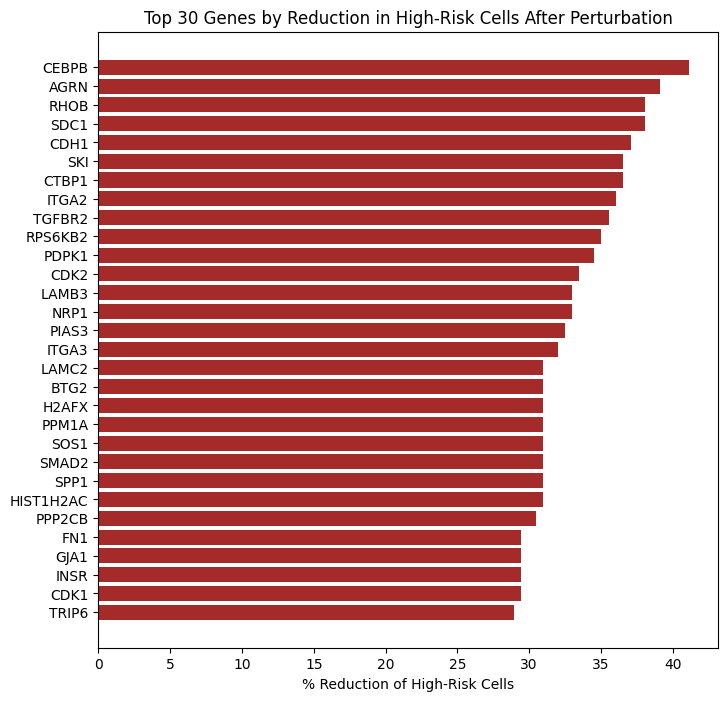

In [8]:
sdh.plot_top_perturbed_genes(percentage_dict, top_n=30)

Vizualisation of the effect of perturbing genes of intrest, where the color legend indicates: 
- gray is for unchanged Background cells (Background to Background), 
- blue is for High-Risk cells transitioned to Background cells (High-Risk to Background)
- purple is for Background cells transitioned to High-Risk cells (Background to High-Risk)
- red is for persistent High-Risk cells (High-Risk to High-Risk).
- blue line represents the calculated perturbation score

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/admin/Documents/GitHub/SIDISH/SIDISH/SIDISH.py:434: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(self.adata, resolution=resolution, random_state=self.seed)


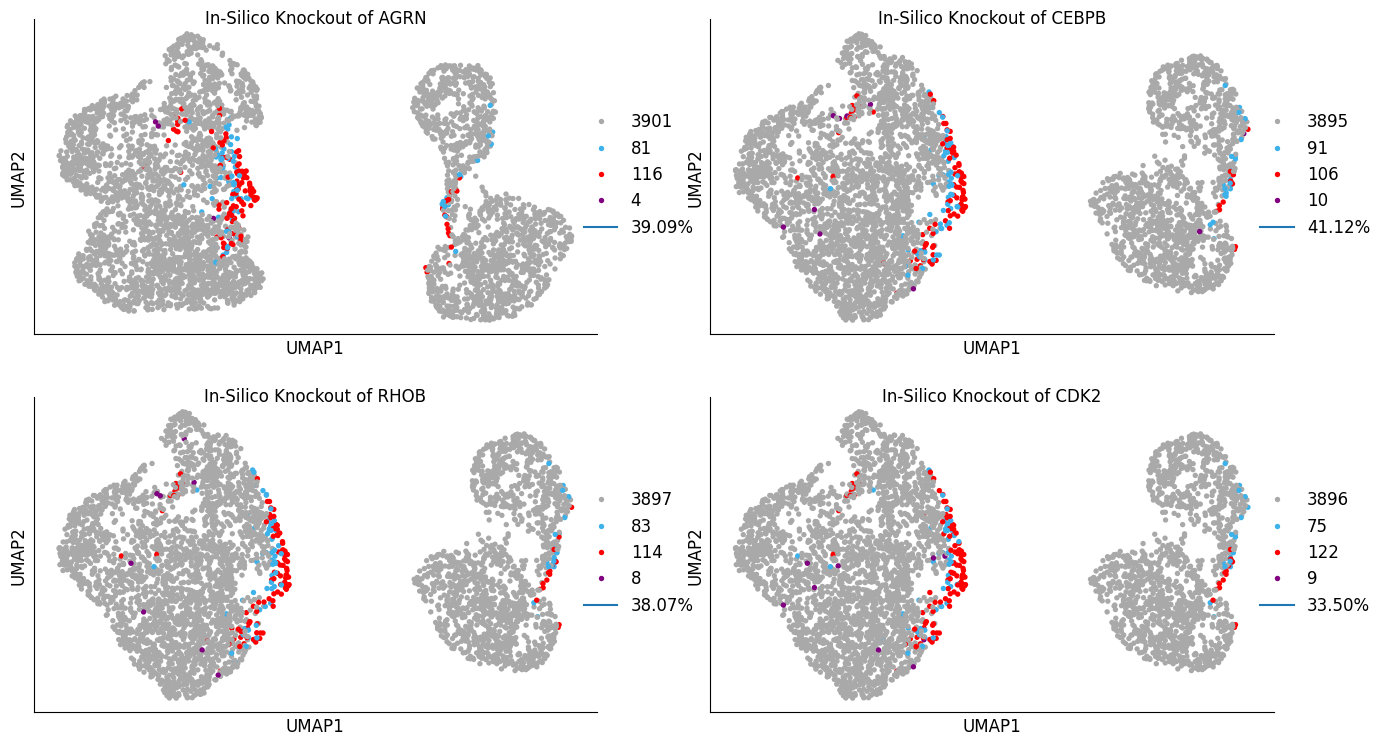

In [9]:
sdh.plot_perturbation_UMAP(['AGRN', 'CEBPB', "RHOB", 'CDK2'], resolution=0.8, celltype=False)

## **Step 4: Run double gene perturbation**

In [ ]:
percentage_double_dict, pvalue_double_dict = sdh.run_double_Perturbation()

  4%|▍         | 15/380 [12:37<2:51:11, 28.14s/it] 

Visualise the effect of perturbing two genes of intrest by ploting a heatmap. 

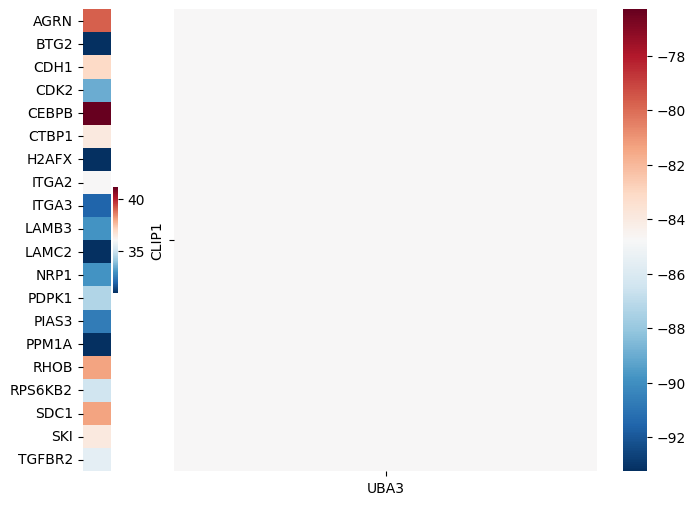

In [ ]:
sdh.plot_double_Perturbation_Heatmap()